## VENTILATOR PRESSURE PREDICTION


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Let's read the data:


In [3]:
train_data = pd.read_csv('ventilatordata/train.csv', index_col = 0)
test_data = pd.read_csv('ventilatordata/train.csv', index_col = 0)


Let's take a look at our datasets


In [4]:
train_data.head()

,breath_id,R,C,time_step,u_in,u_out,pressure
id,,,,,,,
1,1,20,50,0.000000,0.083334,0,5.837492
2,1,20,50,0.033652,18.383041,0,5.907794
3,1,20,50,0.067514,22.509278,0,7.876254
4,1,20,50,0.101542,22.808822,0,11.742872
5,1,20,50,0.135756,25.355850,0,12.234987


In [5]:

# unique values in each feature
train_data.nunique().to_frame()

,0
breath_id,75450
R,3
C,3
time_step,3767571
u_in,4020248
u_out,2
pressure,950


In [6]:

train_data.shape

(6036000, 7)

In [7]:
train_data.groupby('breath_id')['time_step'].count().unique().item()

80


We have, on average, 80 time-steps of data per breath`

#### Missing Data

Let's check for any missing data

In [8]:
train_data.isnull().sum().to_frame()

,0
breath_id,0
R,0
C,0
time_step,0
u_in,0
u_out,0
pressure,0



No missing data is observed. 
Wonderful


#### Time

How long does the longest breath last?


In [9]:
train_data.time_step.max()

2.9372379779815674


Just under 3 seconds.

Activation and Deactivation of the solenoid valve: 


In [10]:
# maximum deactivation time
train_data.query('u_out == 1').time_step.max()


2.9372379779815674

In [11]:

#maximum activation time
train_data.query('u_out == 0').time_step.max()

0.999798059463501


#### All Breaths

Values for R - represent how restricted the airway is (in cmH2O/L/S).

Lets look at all the values:



In [12]:
train_data.R.value_counts().to_frame()

,R
50,2410080
5,1988800
20,1637120



For the values of C, the lung attribute indicates how compliant the lung is (in (in mL/cmH2O)



In [13]:
train_data.C.value_counts().to_frame()

,C
10,2244720
50,1971680
20,1819600



Lets have a look at the pressure.

This is the airway pressure measured in the respiratory circuit - in cmH2O. 1 cmH20 is around 98  Pascals.



In [14]:
# maximum pressure measured
train_data.pressure.max()

64.82099173863949


At 64.820 cmH20, which corresponds to around 6,350Pa, the highest pressure in our dataset is curiously well below the atmospheric pressure (101,325 Pa)

Lets see how the pressure is distributed


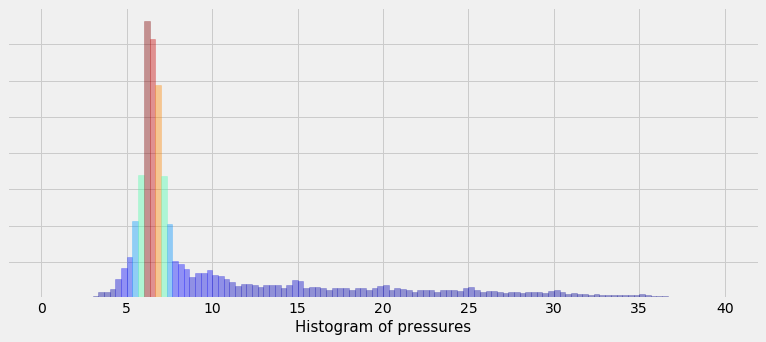

In [15]:
plt.figure(figsize = (12,5)) # size of the plot

# the histogram dimensions, size of bars and colors
ax = sns.distplot(train_data['pressure'],
                  bins=120,
                  kde_kws={"clip":(0,40)},
                  hist_kws={"range":(0,40)},
                  color='mediumorchid',
                  kde=False
                 )

# working with numpy arrays
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))

for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
    
plt.xlabel('Histogram of pressures', size = 15)
ax.set(yticklabels=[])
plt.show()

In [16]:
train_data.pressure.describe()

count    6.036000e+06
mean     1.122041e+01
std      8.109703e+00
min     -1.895744e+00
25%      6.329607e+00
50%      7.032628e+00
75%      1.364103e+01
max      6.482099e+01
Name: pressure, dtype: float64



We have to note that in this dataset, we are dealing with 2 phases of the ventilation process. The inspiratory phase and the expiratory phase. Our task at hand is to predict the **airway pressure in the circuit during the breath**, and so, as a result, the expiratory phase is not scored.

For practical purposes we will only work with the pressure only when `u_out=0`


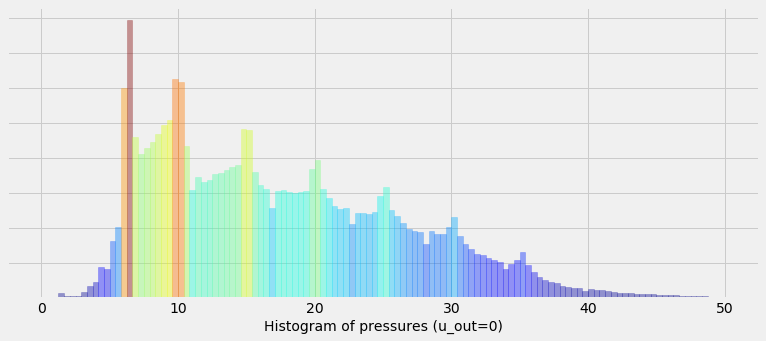

In [17]:

u_out_zero = train_data.query('u_out == 0').reset_index(drop = True)
plt.figure(figsize = (12,5))
ax = sns.distplot(u_out_zero['pressure'],
                 bins = 120,
                 kde_kws={"clip":(0,50)}, 
                 hist_kws={"range":(0,50)},
                 color='mediumorchid', 
                 kde=False)

values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))

for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
    
plt.xlabel("Histogram of pressures (u_out=0)", size = 14)
ax.set(yticklabels=[])
plt.show()

In [18]:
pd.set_option('display.float_format', '{:.4f}'.format)
u_out_zero.pressure.describe().to_frame()

,pressure
count,2290968.0000
mean,17.5962
std,9.2479
min,-1.8957
25%,9.9150
50%,15.8204
75%,23.9754
max,64.8210



We have 9 different combinations of experiments:
`C` can be 10, 20, 50
and `R` can be 5, 20, 50. 

Let's look at each:


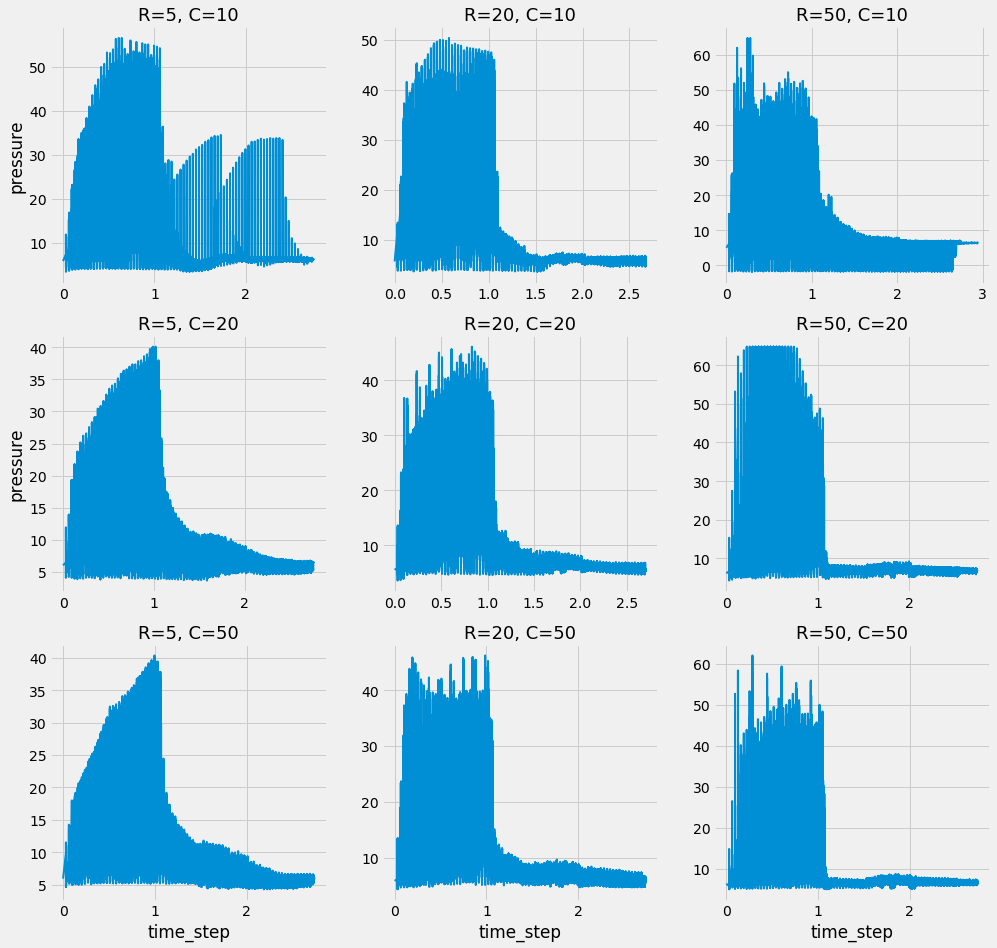

In [19]:
first_comb = train_data.query('C == 10 and R == 5').reset_index(drop = True) # id 39
second_comb = train_data.query('C == 10 and R == 20') # id 21
third_comb = train_data.query('C == 10 and R == 50') # id 18
fourth_comb = train_data.query('C == 20 and R == 5') # id 17
fifth_comb = train_data.query('C == 20 and R == 20') # id 2
sixth_comb = train_data.query('C == 20 and R == 50') # id 3
seventh_comb = train_data.query('C == 50 and R == 5') # id 5
eighth_comb = train_data.query('C == 50 and R == 20') # id 1
ninth_comb = train_data.query('C == 50 and R == 50') # id 4

# plots

fig, axes = plt.subplots(3, 3, figsize=(15,15))
sns.lineplot(data=first_comb, x='time_step', y='pressure', lw=2, ci = None, ax=axes[0,0])
axes[0,0].set_title('R=5, C=10', fontsize=18)
axes[0,0].set(xlabel='')

sns.lineplot(data=second_comb, x="time_step", y="pressure",  lw=2, ci = None, ax=axes[0,1])
axes[0,1].set_title ("R=20, C=10", fontsize=18)
axes[0,1].set(xlabel='')
axes[0,1].set(ylabel='')

sns.lineplot(data=third_comb, x="time_step", y="pressure",  lw=2, ci = None, ax=axes[0,2])
axes[0,2].set_title ("R=50, C=10", fontsize=18)
axes[0,2].set(xlabel='')
axes[0,2].set(ylabel='')

sns.lineplot(data=fourth_comb, x="time_step", y="pressure",  lw=2, ci = None, ax=axes[1,0])
axes[1,0].set_title ("R=5, C=20", fontsize=18)
axes[1,0].set(xlabel='')

sns.lineplot(data=fifth_comb, x="time_step", y="pressure",  lw=2, ci = None, ax=axes[1,1])
axes[1,1].set_title ("R=20, C=20", fontsize=18)
axes[1,1].set(xlabel='')
axes[1,1].set(ylabel='')

sns.lineplot(data=sixth_comb, x="time_step", y="pressure",  lw=2, ci = None, ax=axes[1,2])
axes[1,2].set_title ("R=50, C=20", fontsize=18)
axes[1,2].set(xlabel='')
axes[1,2].set(ylabel='')

sns.lineplot(data=seventh_comb, x="time_step", y="pressure",  lw=2, ci = None, ax=axes[2,0])
axes[2,0].set_title ("R=5, C=50", fontsize=18)
axes[2,0].set(ylabel='')

sns.lineplot(data=eighth_comb, x="time_step", y="pressure",  lw=2, ci = None, ax=axes[2,1])
axes[2,1].set_title ("R=20, C=50", fontsize=18)
axes[2,1].set(ylabel='')

sns.lineplot(data=ninth_comb, x="time_step", y="pressure",  lw=2, ci = None, ax=axes[2,2])
axes[2,2].set_title ("R=50, C=50", fontsize=18)
axes[2,2].set(ylabel='')

plt.show()



It is also worth noting that even before the experiments start, when the `time_step` is 0 and `u_in`=  0, there is a positive pressure in the airway.

The ventilator system is maintained above atmospheric pressure to allow gas exchange to the lung



In [20]:

# zero-times
zero_time = train_data.query("time_step < 0.000001 & u_in < 0.000001").reset_index(drop = True)
zero_time_5_10  = zero_time.query("R ==  5 & C == 10").reset_index(drop = True)
zero_time_5_20  = zero_time.query("R ==  5 & C == 20").reset_index(drop = True)
zero_time_5_50  = zero_time.query("R ==  5 & C == 50").reset_index(drop = True)
zero_time_20_10 = zero_time.query("R == 20 & C == 10").reset_index(drop = True)
zero_time_20_20 = zero_time.query("R == 20 & C == 20").reset_index(drop = True)
zero_time_20_50 = zero_time.query("R == 20 & C == 50").reset_index(drop = True)
zero_time_50_10 = zero_time.query("R == 50 & C == 10").reset_index(drop = True)
zero_time_50_20 = zero_time.query("R == 50 & C == 20").reset_index(drop = True)
zero_time_50_50 = zero_time.query("R == 50 & C == 50").reset_index(drop = True)

[(3, 8)]

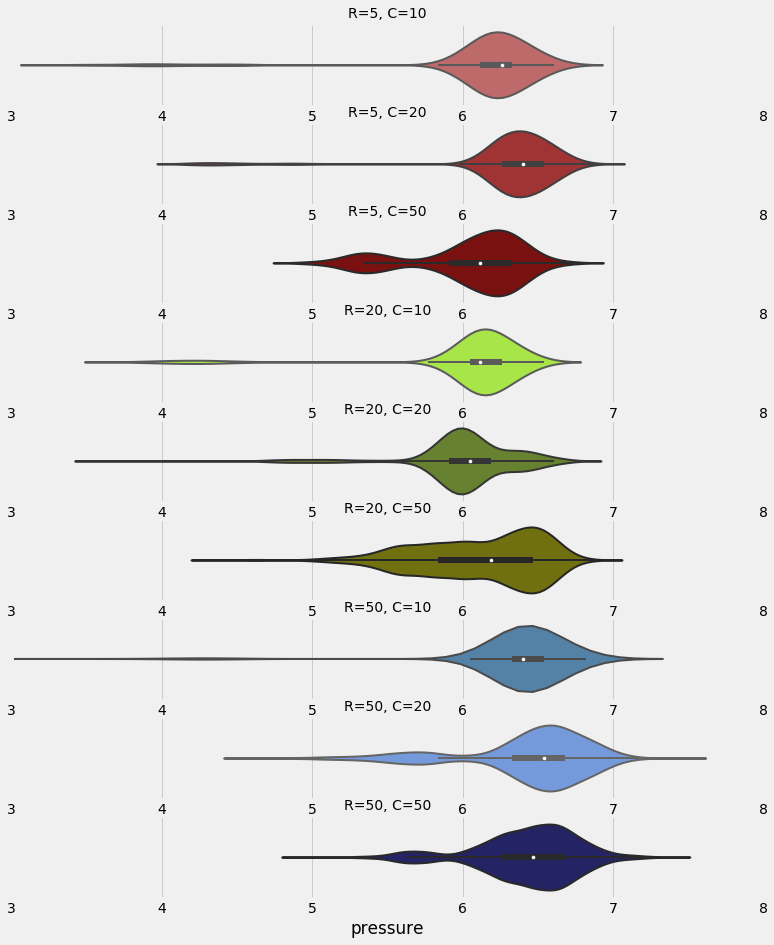

In [21]:

# plots
fig, axes = plt.subplots(9, 1, figsize = (12, 15))
sns.violinplot(x = zero_time_5_10.pressure, linewidth = 2, ax = axes [0], color = "indianred")
axes[0].set_title("R=5, C=10", fontsize=14)
axes[0].set(xlim=(3, 8))

sns.violinplot(x=zero_time_5_20["pressure"], linewidth=2, ax=axes[1], color="firebrick")
axes[1].set_title ("R=5, C=20", fontsize=14)
axes[1].set(xlim=(3, 8))

sns.violinplot(x=zero_time_5_50["pressure"], linewidth=2, ax=axes[2], color="darkred" )
axes[2].set_title ("R=5, C=50", fontsize=14)
axes[2].set(xlim=(3, 8))

sns.violinplot(x=zero_time_20_10["pressure"], linewidth=2, ax=axes[3], color="greenyellow")
axes[3].set_title ("R=20, C=10", fontsize=14)
axes[3].set(xlim=(3, 8))

sns.violinplot(x=zero_time_20_20["pressure"], linewidth=2, ax=axes[4], color="olivedrab")
axes[4].set_title ("R=20, C=20", fontsize=14)
axes[4].set(xlim=(3, 8))

sns.violinplot(x=zero_time_20_50["pressure"], linewidth=2, ax=axes[5], color="olive" )
axes[5].set_title ("R=20, C=50", fontsize=14)
axes[5].set(xlim=(3, 8))

sns.violinplot(x=zero_time_50_10["pressure"], linewidth=2, ax=axes[6], color="steelblue")
axes[6].set_title ("R=50, C=10", fontsize=14)
axes[6].set(xlim=(3, 8))

sns.violinplot(x=zero_time_50_20["pressure"], linewidth=2, ax=axes[7], color="cornflowerblue")
axes[7].set_title ("R=50, C=20", fontsize=14)
axes[7].set(xlim=(3, 8))

sns.violinplot(x=zero_time_50_50["pressure"], linewidth=2, ax=axes[8], color="midnightblue" )
axes[8].set_title ("R=50, C=50", fontsize=14)
axes[8].set(xlim=(3, 8))

In [22]:

# at zero-time
zero_time.pressure.describe().to_frame()

,pressure
count,23028.0000
mean,6.2684
std,0.5541
min,-1.8254
25%,6.1187
50%,6.3999
75%,6.5405
max,7.4544




From the descriptive analytics above, at zero time, the lowest pressure of the airway is a negative value, presicely at -1.8254cmH2O.

It is also important to note that **not** all cycles start with the inspiratory solenoid valve set at 0 ( when `u_in` = 0)


**Negative Pressure** - when `u_in` = 0 and at `time_step` = 0


In [23]:
zero_time[zero_time['pressure'] == zero_time['pressure'].min()]

,breath_id,R,C,time_step,u_in,u_out,pressure
114,542,50,10,0.0000,0.0000,0,-1.8254
21863,119582,50,10,0.0000,0.0000,0,-1.8254


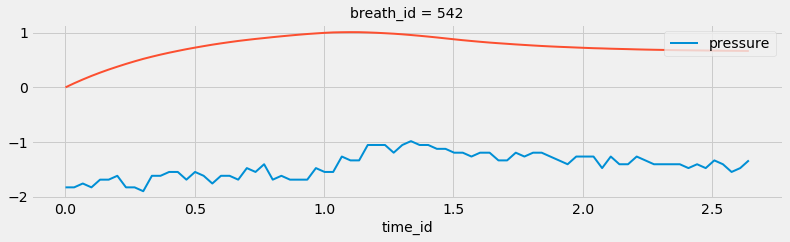

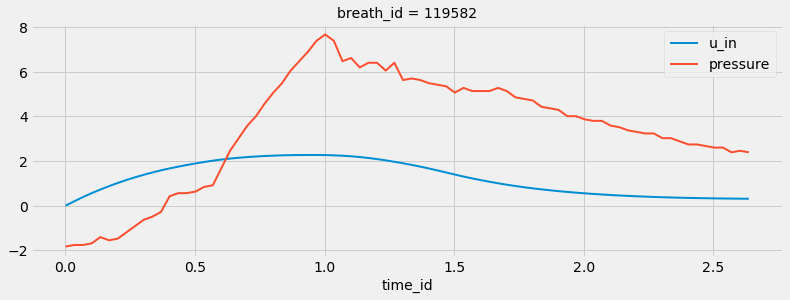

In [24]:

# breath 542
breath_542 = train_data.query('breath_id == 542').reset_index(drop = True)
fig, ax = plt.subplots(1, 1, figsize = (12, 3))
ax.plot(breath_542['time_step'], breath_542['pressure'], lw = 2, label = "pressure")
ax.legend(loc = "upper right")
ax.plot(breath_542["time_step"],breath_542["u_in"], lw=2, label='u_in')
ax.set_xlabel("time_id", fontsize=14)
ax.set_title("breath_id = 542", fontsize=14)
plt.show();

# breath 119582
breath_119582 = train_data.query('breath_id == 119582').reset_index(drop = True)
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(breath_119582["time_step"],breath_119582["u_in"], lw=2, label='u_in')
ax.plot(breath_119582["time_step"],breath_119582["pressure"], lw=2, label='pressure')
#ax.set(xlim=(0,1))
ax.legend(loc="upper right")
ax.set_xlabel("time_id", fontsize=14)
ax.set_title("breath_id = 119582", fontsize=14)
plt.show();


All the instances of negative pressure occur in `R = 50` (high restriction) with `C = 10`(thicker latex) systems 

Another feature we can look at is the cumulative sum total of the air pumped into the lungs. This feature is assumed to be proportional to the total pressure in the lungs at each given point.
Again, this is only useful during the inspiratory phase of the ventilation.



In [25]:
train_data['u_in_cumsum'] = (train_data['u_in']).groupby(train_data['breath_id']).cumsum()
train_data['pressure_prop'] =  train_data.u_in_cumsum/train_data.pressure
print(train_data[['pressure', 'u_in_cumsum', 'pressure_prop']].head())


    pressure  u_in_cumsum  pressure_prop
id                                      
1     5.8375       0.0833         0.0143
2     5.9078      18.4664         3.1258
3     7.8763      40.9757         5.2024
4    11.7429      63.7845         5.4318
5    12.2350      89.1403         7.2857



Lets look at an ocsillatory experiment between the two features:


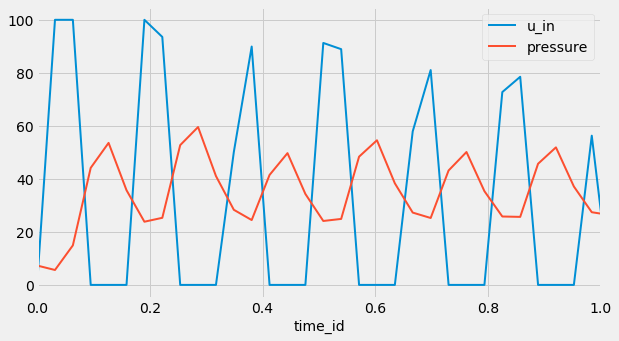

In [26]:
# we'll use breath 928 since its a good example
# we'll also limit it to only the first second
breath_928 = train_data.query('breath_id == 928').reset_index(drop = True)
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.plot(breath_928["time_step"],breath_928["u_in"], lw=2, label='u_in')
ax.plot(breath_928["time_step"],breath_928["pressure"], lw=2, label='pressure')
ax.set(xlim=(0,1))
ax.legend(loc="upper right")
ax.set_xlabel("time_id", fontsize=14)
plt.show();


Its interesting to note that there is a slight lag, of about .1 of a second.
During prediction, a shift has to be made so as to make the features in-line, due to the delay observed.


Let's now build our baseline models:




In [27]:

# group by the id, and return the index of the last time step
idxmax_time_step = train_data.groupby('breath_id')['time_step'].idxmax()

# locate the values(  of breath_id and u_in) in the indexes
last_value_u_in = train_data.loc[idxmax_time_step, ['breath_id','u_in']]
last_value_u_in.columns = ['breath_id','last_value_u_in']

train = train_data.merge(last_value_u_in, on = 'breath_id')


idxmax_time_step = test_data.groupby('breath_id')['time_step'].idxmax()
last_value_u_in = test_data.loc[idxmax_time_step, ['breath_id','u_in']]
last_value_u_in.columns = ['breath_id','last_value_u_in']

test = test_data.merge(last_value_u_in, on='breath_id')

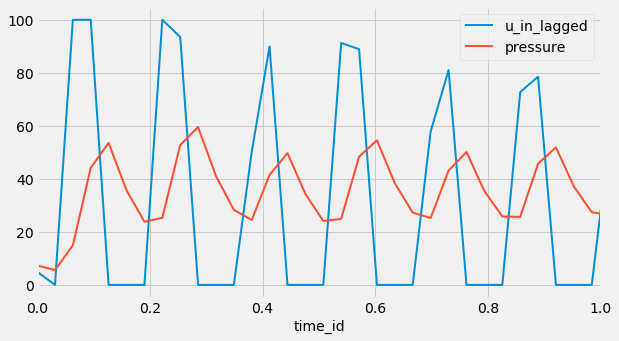

In [28]:
import time
import lightgbm as lgbm
from sklearn import metrics 

# add lag to u_in
train['u_in_lagged'] = train['u_in'].shift(1)
train = train.fillna(0)




# breath_928 visual
breath_928 = train.query('breath_id == 928').reset_index(drop = True)
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.plot(breath_928["time_step"],breath_928["u_in_lagged"], lw=2, label='u_in_lagged')
ax.plot(breath_928["time_step"],breath_928["pressure"], lw=2, label='pressure')
ax.set(xlim=(0,1))
ax.legend(loc="upper right")
ax.set_xlabel("time_id", fontsize=14)
plt.show();



In [66]:
# test_data = pd.read_csv('ventilatordata/test.csv', index_col = 0)

# test_data['u_in_cumsum'] = (test_data['u_in']).groupby(test_data['breath_id']).cumsum()

# test_data['pressure_prop'] =  test_data.u_in_cumsum/test_data.pressure
# print(train_data[['pressure', 'u_in_cumsum', 'pressure_prop']].head())
# idxmax_time_step = test_data.groupby('breath_id')['time_step'].idxmax()
# last_value_u_in = test_data.loc[idxmax_time_step, ['breath_id','u_in']]
# last_value_u_in.columns = ['breath_id','last_value_u_in']

test = test_data.merge(last_value_u_in, on='breath_id')
test['u_in_lagged'] = test['u_in'].shift(1)
test = test.fillna(0)
train.head()

,breath_id,R,C,time_step,u_in,u_out,pressure,u_in_cumsum,pressure_prop,last_value_u_in,u_in_lagged
0,1,20,50,0.0000,0.0833,0,5.8375,0.0833,0.0143,4.9871,0.0000
1,1,20,50,0.0337,18.3830,0,5.9078,18.4664,3.1258,4.9871,0.0833
2,1,20,50,0.0675,22.5093,0,7.8763,40.9757,5.2024,4.9871,18.3830
3,1,20,50,0.1015,22.8088,0,11.7429,63.7845,5.4318,4.9871,22.5093
4,1,20,50,0.1358,25.3559,0,12.2350,89.1403,7.2857,4.9871,22.8088



The features look abit more proportional now

Lets fit our first baseline model:


In [29]:
lgb_base = lgbm.LGBMRegressor()

start_lgb_base = time.time()
lgb_base.fit(train.drop(['breath_id', 'pressure'], axis = 1), train['pressure'])
end_lgb_base = time.time()


In [30]:
print("Train time: {}". format(end_lgb_base - start_lgb_base))

Train time: 18.831394910812378


In [31]:

#predictions + submission + scoring

preds = lgb_base.predict(test.drop(['breath_id', 'pressure'], axis = 1))
test['pressure'] = preds

submission = pd.read_csv('ventilatordata/submission.csv')
submission['pressure'] = test['pressure']

# submission.to_csv('submission1.csv', index = False)

Score: 1.095

Lets enhance our first model a little

In [77]:
from sklearn.model_selection import GroupKFold 
from sklearn.model_selection import  KFold

features = ["R", "C", "time_step", "u_in", "u_out"]
target = train["pressure"]
scores = []
feature_importance = pd.DataFrame()
models = []
columns = [col for col in train.columns if col not in ['id', 'pressure', 'pressure_prop']]
X = train[columns]
y = train['pressure']

params = {
    'objective': 'regression',
          'learning_rate': 0.25,
          "boosting_type": "gbdt",
          'min_data_in_leaf':600,
          'max_bin': 196,
          'feature_fraction':0.4,
          'lambda_l1':36, 'lambda_l2':80,
          'max_depth':15,
          'num_leaves':1000,
          "metric": 'mae',
          'n_jobs': -1
}

folds = GroupKFold(n_splits=5)

for fold_n, (train_index, valid_index) in enumerate(folds.split(train, y, groups=train['breath_id'])):
    print(f'Fold {fold_n} started at {time.ctime()}')
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    lgb_model = lgbm.LGBMRegressor( **params, n_estimators = 8000)
    lgb_model.fit(X_train, y_train, 
    eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose = 100, early_stopping_rounds = 10)
    score =  metrics.mean_absolute_error(y_valid, lgb_model.predict(X_valid))
        
    models.append(lgb_model)
    scores.append(score)
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = columns
    fold_importance["importance"] = lgb_model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))


Fold 0 started at Wed Sep 29 21:45:05 2021
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] lambda_l1 is set=36, reg_alpha=0.0 will be ignored. Current value: lambda_l1=36
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
Training until validation scores don't improve for 10 rounds
[100]	training's l1: 0.725251	valid_1's l1: 0.763549
[200]	training's l1: 0.646219	valid_1's l1: 0.704358
[300]	training's l1: 0.609336	valid_1's l1: 0.680656
[400]	training's l1: 0.585928	valid_1's l1: 0.668534
Early stopping, best iteration is:
[454]	training's l1: 0.576131	valid_1's l1: 0.663928
Fold 1 started at Wed Sep 29 21:49:12 2021
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value:

In [80]:
for model in models:
    predictions = lgb_model.predict(test[columns])


In [82]:
submission['pressure'] = predictions

submission.to_csv('submission2.csv', index=False)
